In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pytmatrix.tmatrix import Scatterer
from pytmatrix import orientation, radar, tmatrix_aux, refractive
%matplotlib inline

### First we will check validity of Rayleigh approximation
Run these calculations for various frequencies

In [2]:
D = np.linspace(0.1,8.0,100) # Should be volume eq. diameter for most computations

# Spherical raindrops
# Rayleigh approximation for radar cross section
rcs_ray = (np.pi**5)*tmatrix_aux.K_w_sqr[tmatrix_aux.wl_C] / (tmatrix_aux.wl_C**4) * (D**6)

# Spheroidal raindrops
# T-matrix calculations of RCS
rcs_sph = np.zeros(D.shape) # Radar cross section for a spherical drop computed using T-matrix
rcs_rdr = np.zeros(D.shape) # Radar cross section for a spheroidal drop computed using T-matrix

for indx in range(0,len(D)):
    # T-matrix sphere
    scatterer   = Scatterer(radius=D[indx]/2, wavelength=tmatrix_aux.wl_C,
                            m=refractive.m_w_10C[tmatrix_aux.wl_C], axis_ratio=1.0/1.0)
    scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
    rcs_sph[indx] = radar.radar_xsect(scatterer=scatterer)
    
    # T-matrix raindrops with Thurai et al (2007) axis ratios
    scatterer   = Scatterer(radius=D[indx]/2, wavelength=tmatrix_aux.wl_C,
                            m=refractive.m_w_10C[tmatrix_aux.wl_C], axis_ratio=1.0/tmatrix_aux.dsr_thurai_2007(D[indx]))
    scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
    rcs_rdr[indx] = radar.radar_xsect(scatterer=scatterer)
    

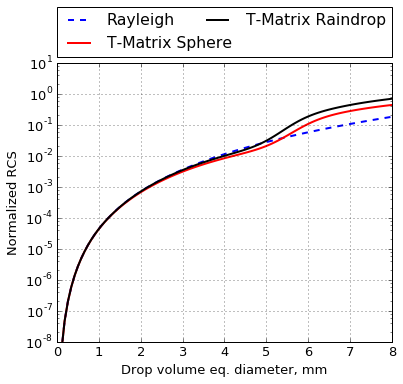

In [3]:
plots=[]
fig = plt.figure(figsize=[6,5])
font = {'size': 13}
plt.rc('font',**font)
plt.semilogy(D,rcs_ray / ((np.pi/4)*(D**2)), linestyle='--', color='b', linewidth=2.0, label="Rayleigh")
plt.semilogy(D,rcs_sph / ((np.pi/4)*(D**2)), linestyle='-', color='r', linewidth=2.0,  label="T-Matrix Sphere")
plt.semilogy(D,rcs_rdr / ((np.pi/4)*(D**2)), linestyle='-', color='k', linewidth=2.0,  label="T-Matrix Raindrop")
plt.xlabel("Drop volume eq. diameter, mm")
plt.ylabel("Normalized RCS")

plt.gca().set_xlim([0.0,8.0])
plt.gca().set_ylim([1e-8,1e1]) 
plt.grid(True)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### Refractive index of ice particles

Refractive indeces of ice particles can be calculate using Effective Medium Approximation (EMA), i.e Maxwell Garnett, Bruggeman, etc. The refractive index is determined by particle density, which need to be converted to volume fraction. 

In [4]:
dagg  = np.linspace(0.0001, 1.0, 100)  # range of d (cm) - eq. volume diameter
magg  = 18.34*(1e-4)*np.power(dagg,1.4)
ar = 0.6 # we assume that particles are spheroids with the axis ratio
dens  = magg/((np.pi/6.0)*ar*np.power(dagg,3.0))
dens =  dens.clip(min=None, max=refractive.ice_density)

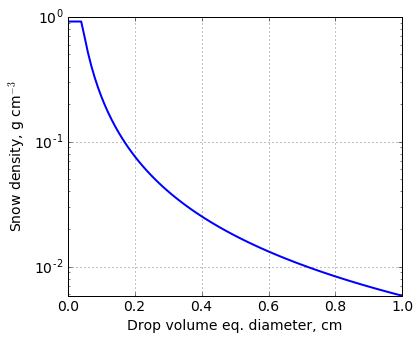

In [5]:
plots=[]
fig = plt.figure(figsize=[6,5])
font = {'size': 14}
plt.rc('font',**font)
plt.semilogy(dagg, dens, linestyle='-', color='b', linewidth=2.0)
plt.xlabel("Drop volume eq. diameter, cm")
plt.ylabel("Snow density, g cm$^{-3}$")

plt.gca().set_xlim([0.0,1.0])
plt.gca().set_ylim([0,1]) 
plt.grid(True)
plt.show()

#### No we use EMA to calculate refractive index
To do so we need to decide how the particle is composed, is it air included into a matrix of ice (a-i) or otherwise (i-a). This is important for the Maxwell Garnett aproximation. The Brugeman aproximation, on the other hand, is symetric. The calculations below demonstrate this.

In [6]:
m_ice  = refractive.mi(tmatrix_aux.wl_C, refractive.ice_density) # refractive index of pure ice
m_bg_ai   = np.zeros(dens.shape,dtype=complex)
m_bg_ia   = np.zeros(dens.shape,dtype=complex)
m_mg_ai   = np.zeros(dens.shape,dtype=complex)
m_mg_ia   = np.zeros(dens.shape,dtype=complex)

for indx in range(len(dens)):
    m_tup         = (m_ice,1); 
    mix_tup       = (dens[indx]/refractive.ice_density,1-dens[indx]/refractive.ice_density);
    m_bg_ia[indx] = refractive.bruggeman_refractive(m_tup,mix_tup)
    
    m_tup          = (m_ice,1); 
    m_mg_ia[indx]  = refractive.mg_refractive(m_tup,mix_tup)
    
    m_tup          = (1,m_ice); 
    mix_tup        = (1-dens[indx]/refractive.ice_density,dens[indx]/refractive.ice_density);
    m_mg_ai[indx]  = refractive.mg_refractive(m_tup,mix_tup)
    m_bg_ai[indx]  = refractive.bruggeman_refractive(m_tup,mix_tup)
   

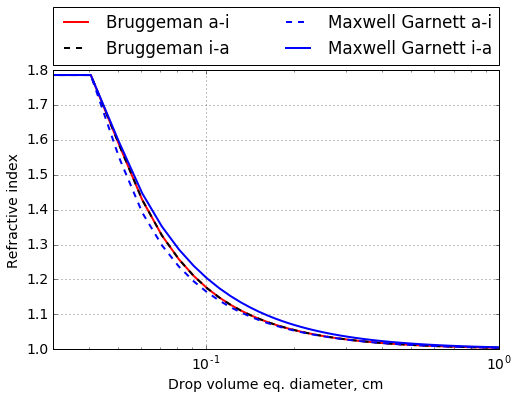

In [7]:
plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 14}
plt.rc('font',**font)
plt.semilogx(dagg, np.real(m_bg_ai), linestyle='-', color='r', linewidth=2.0,  label="Bruggeman a-i")
plt.semilogx(dagg, np.real(m_bg_ia), linestyle='--', color='k', linewidth=2.0,  label="Bruggeman i-a")
plt.semilogx(dagg, np.real(m_mg_ai), linestyle='--', color='b', linewidth=2.0, label="Maxwell Garnett a-i")
plt.semilogx(dagg, np.real(m_mg_ia), linestyle='-', color='b', linewidth=2.0,  label="Maxwell Garnett i-a")
plt.xlabel("Drop volume eq. diameter, cm")
plt.ylabel("Refractive index")

plt.gca().set_xlim([0.03,1.0])
plt.gca().set_ylim([1.0,1.8]) 
plt.grid(True)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### Now let's study dependence of dual-polarization variables on density
The calculations are done for spheroids with a given axis ratio 0.6.
Try different axis ratios, wavelengths.

In [8]:
dens = np.linspace(0.01,0.9,30)
ar   = 0.6
dsnow = 1
kdp_snow = np.zeros(dens.shape)
ldr_snow = np.zeros(dens.shape)
zdr_snow = np.zeros(dens.shape)
rcs_snow = np.zeros(dens.shape)

for indx in range(len(dens)):
         
        # parameter ndgs controls convergence, for particle with ar<0.1 you may need to increase it to 40 or 100
        scatterer = Scatterer(radius=0.5*dsnow, wavelength=tmatrix_aux.wl_C, m=refractive.mi(tmatrix_aux.wl_C, dens[indx]), axis_ratio=1/0.6, ndgs=30) 
        scatterer.or_pdf = orientation.gaussian_pdf(10.0)
        scatterer.orient = orientation.orient_averaged_fixed
        
        ## Kdp
        scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)  
        kdp_snow[indx]=radar.Kdp(scatterer)
         
        ## LDR, Zdr
        scatterer.orient = orientation.orient_averaged_fixed
        scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
    
        ldr_snow[indx]=radar.ldr(scatterer)
        zdr_snow[indx]=radar.Zdr(scatterer)
        rcs_snow[indx]=radar.radar_xsect(scatterer, h_pol=True)

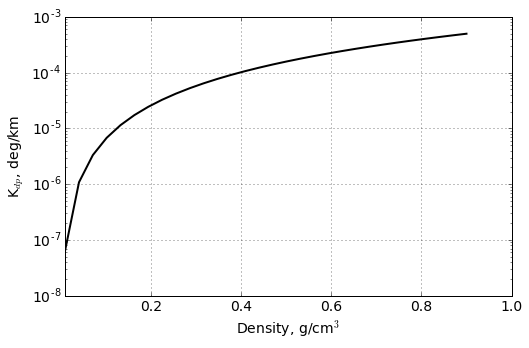

In [9]:
plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 14}
plt.rc('font',**font)
plt.semilogy(dens, kdp_snow, linestyle='-', color='k', linewidth=2.0)
plt.xlabel("Density, g/cm$^3$")
plt.ylabel("K$_{dp}$, deg/km")

plt.gca().set_xlim([0.01,1.0])
#plt.gca().set_ylim([1.0,1.8]) 
plt.grid(True)
plt.show()

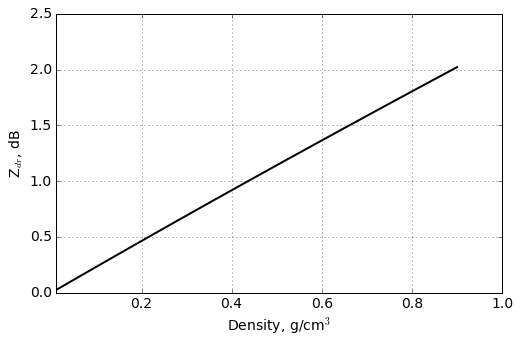

In [16]:
plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 14}
plt.rc('font',**font)
plt.plot(dens, 10*np.log10(zdr_snow), linestyle='-', color='k', linewidth=2.0)
plt.xlabel("Density, g/cm$^3$")
plt.ylabel("Z$_{dr}$, dB")

plt.gca().set_xlim([0.01,1.0])
#plt.gca().set_ylim([1.0,1.8]) 
plt.grid(True)
plt.show()

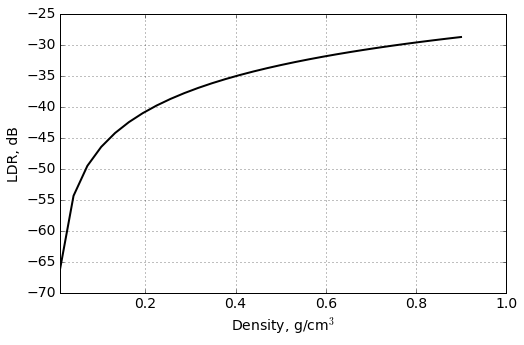

In [17]:
plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 14}
plt.rc('font',**font)
plt.plot(dens, 10*np.log10(ldr_snow), linestyle='-', color='k', linewidth=2.0)
plt.xlabel("Density, g/cm$^3$")
plt.ylabel("LDR, dB")

plt.gca().set_xlim([0.01,1.0])
#plt.gca().set_ylim([1.0,1.8]) 
plt.grid(True)
plt.show()

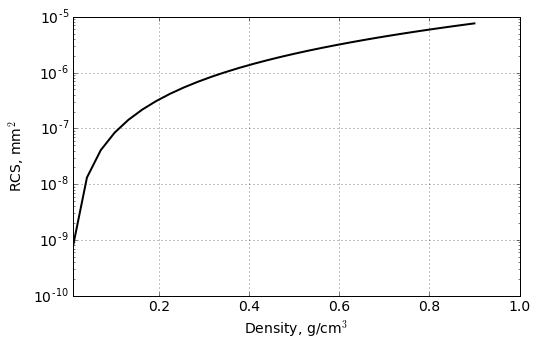

In [14]:
plots=[]
fig = plt.figure(figsize=[8,5])
font = {'size': 14}
plt.rc('font',**font)
plt.semilogy(dens, rcs_snow, linestyle='-', color='k', linewidth=2.0)
plt.xlabel("Density, g/cm$^3$")
plt.ylabel("RCS, mm$^2$")

plt.gca().set_xlim([0.01,1.0])
#plt.gca().set_ylim([1.0,1.8]) 
plt.grid(True)
plt.show()